In [1]:

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import norm

In [2]:
# Wczytaj plik
df = pd.read_csv('fuel_output.csv', sep=';')

# Wyodrębnij kolumny do zmiennych
dates = pd.to_datetime(df['Date'])

fuel_data = df['fuel_data']
logret_fuel_data = df['logret_fuel_data'][1:]
logret_fuel_data=logret_fuel_data.values

A) metoda parametryczna - paliwo t-student

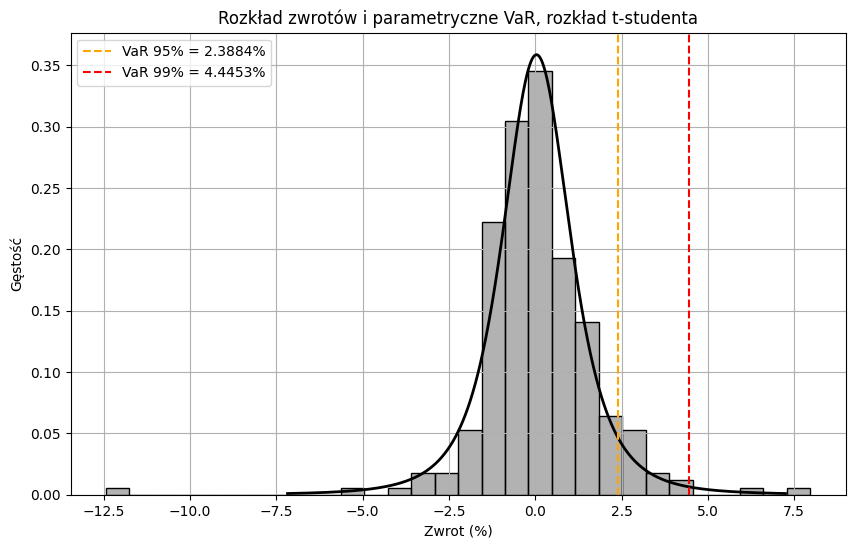

3.243723713943763 0.000355716098170116 0.010305755405206837


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns


# Dopasowanie rozkładu studenta-t
df, loc, scale = stats.t.fit(logret_fuel_data)

# Wyznaczenie VaR na prawej stronie (duże zyski = prawe ogony)
alpha_95 = 0.95
alpha_99 = 0.99

z_95 = stats.t.ppf(alpha_95, df)
z_99 = stats.t.ppf(alpha_99, df)

VaR_95 = loc + z_95 * scale
VaR_99 = loc + z_99 * scale

x = np.linspace(loc - 7*scale, loc + 7*scale, 1000)
pdf = stats.t.pdf(x, df, loc, scale) / 100


x = x * 100

# Rysowanie
plt.figure(figsize=(10, 6))
sns.histplot(logret_fuel_data * 100, stat='density', bins=30, color='gray', alpha=0.6)
plt.plot(x, pdf, linewidth=2, color='black')

# Linie VaR (po prawej stronie)
plt.axvline(VaR_95 * 100, color='orange', linestyle='--', label=f"VaR 95% = {VaR_95*100:.4f}%")
plt.axvline(VaR_99 * 100, color='red', linestyle='--', label=f"VaR 99% = {VaR_99*100:.4f}%")

# Oznaczenia
plt.title('Rozkład zwrotów i parametryczne VaR, rozkład t-studenta')
plt.xlabel('Zwrot (%)')
plt.ylabel('Gęstość')
plt.legend()
plt.grid(True)
plt.show()
print(df, loc, scale)


test Kolmogorova-Smirnova

KS test D-statistic: 0.0442
KS test p-value: 0.6949


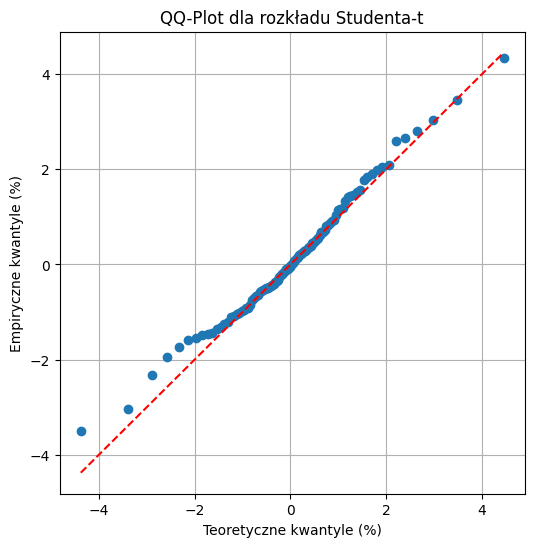

In [4]:

# Test dopasowania: Kolmogorov-Smirnov
D_statistic, p_value = stats.kstest(logret_fuel_data, 't', args=(df, loc, scale))

print(f"KS test D-statistic: {D_statistic:.4f}")
print(f"KS test p-value: {p_value:.4f}")

# QQ-plot (kwantyl-kwantyl)
theoretical_quantiles = stats.t.ppf(np.linspace(0.01, 0.99, 100), df, loc, scale)
sample_quantiles = np.quantile(logret_fuel_data, np.linspace(0.01, 0.99, 100))

plt.figure(figsize=(6, 6))
plt.plot(theoretical_quantiles * 100, sample_quantiles * 100, 'o')
plt.plot(theoretical_quantiles * 100, theoretical_quantiles * 100, 'r--')
plt.title('QQ-Plot dla rozkładu Studenta-t')
plt.xlabel('Teoretyczne kwantyle (%)')
plt.ylabel('Empiryczne kwantyle (%)')
plt.grid(True)
plt.show()


b) metoda historyczna

i) zwykla

In [5]:
alpha_95 = 0.95
alpha_99 = 0.99

# Historyczny VaR (zwykły)
VaR_hist_95 = np.percentile(logret_fuel_data, 100 * alpha_95)
VaR_hist_99 = np.percentile(logret_fuel_data, 100 * alpha_99)

print(f"Historyczny VaR 95% (zwykły): {VaR_hist_95*100:.4f}%")
print(f"Historyczny VaR 99% (zwykły): {VaR_hist_99*100:.4f}%")


Historyczny VaR 95% (zwykły): 2.6462%
Historyczny VaR 99% (zwykły): 4.3359%


ii) ważony -  wagi wykładnicze, czyli najnowsze dane mają większe znaczenie.

In [13]:
# przykładowe dane

alpha_95 = 0.95
alpha_99 = 0.99

# Parametry wag
lambda_ = 0.94
n = len(logret_fuel_data)

# Wagi wykładnicze
weights = (1 - lambda_) * (lambda_ ** np.arange(n))
weights = weights[::-1]  # Najnowsze dane mają największe wagi
weights /= weights.sum()  # Normalizacja

# Sortowanie danych i wag

sorted_indices = np.argsort(logret_fuel_data)
sorted_returns = logret_fuel_data[sorted_indices]
sorted_weights = weights[sorted_indices]

# Skumulowane wagi
cum_weights = np.cumsum(sorted_weights)

# Funkcja do wyszukiwania VaR przy skumulowanych wagach
def weighted_var(cum_weights, sorted_returns, alpha):
    idx = np.searchsorted(cum_weights, alpha, side="left")  # UWAGA: szukamy 1 - alpha
    idx = min(idx, len(sorted_returns) - 1)  # Zabezpieczenie
    return sorted_returns[idx]

# Obliczenie VaR 95% i 99%
VaR_weighted_95 = weighted_var(cum_weights, sorted_returns, alpha_95)
VaR_weighted_99 = weighted_var(cum_weights, sorted_returns, alpha_99)

print(f"Historyczny VaR 95% (ważony): {VaR_weighted_95*100:.4f}%")
print(f"Historyczny VaR 99% (ważony): {VaR_weighted_99*100:.4f}%")


Historyczny VaR 95% (ważony): 2.8020%
Historyczny VaR 99% (ważony): 2.8884%


In [8]:


# Parametry
lambda_ = 0.96
alpha_95 = 0.95
alpha_99 = 0.99

# Dane: załóżmy, że masz już wczytane logret_fuel_data jako np.array
n = len(logret_fuel_data)

# 1. Wyznaczanie wag wykładniczych zgodnie z metodą
raw_weights = lambda_ ** np.arange(n-1, -1, -1)  # lambda^0 dla najnowszej obserwacji
w1 = (1 - lambda_) / (1 - lambda_ ** n)           # Wyznaczenie w(1) z warunku normalizacji
weights = w1 * raw_weights                       # Ostateczne wagi
weights /= weights.sum()                         # (opcjonalna dodatkowa normalizacja dla bezpieczeństwa)

# 2. Sortowanie danych wg wartości zwrotów
sorted_indices = np.argsort(logret_fuel_data)
sorted_returns = logret_fuel_data[sorted_indices]
sorted_weights = weights[sorted_indices]

# 3. Skumulowane prawdopodobieństwa
cum_weights = np.cumsum(sorted_weights)

# 4. Funkcja do wyszukiwania VaR
def weighted_var(cum_weights, sorted_returns, alpha):
    target = alpha  # szukamy kwantyla na poziomie 1 - alpha
    idx = np.searchsorted(cum_weights, target, side="left")
    idx = min(idx, len(sorted_returns) - 1)  # zabezpieczenie
    return sorted_returns[idx]

# 5. Obliczenie VaR
VaR_weighted_95 = weighted_var(cum_weights, sorted_returns, alpha_95)
VaR_weighted_99 = weighted_var(cum_weights, sorted_returns, alpha_99)

print(f"Historyczny VaR 95% (ważony): {VaR_weighted_95*100:.4f}%")
print(f"Historyczny VaR 99% (ważony): {VaR_weighted_99*100:.4f}%")


Historyczny VaR 95% (ważony): 2.8020%
Historyczny VaR 99% (ważony): 2.8884%


iii) GARCH

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                680.538
Distribution:                  Normal   AIC:                          -1353.08
Method:            Maximum Likelihood   BIC:                          -1338.97
                                        No. Observations:                  251
Date:                Mon, Apr 28 2025   Df Residuals:                      250
Time:                        20:31:22   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.8238e-04  1.777e-03     -0.159      0.

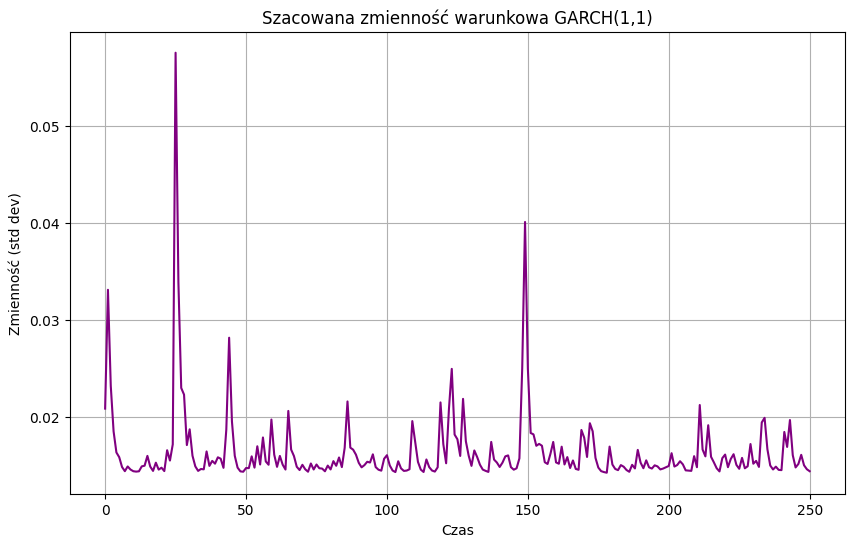

In [10]:
from arch import arch_model

# Przygotowanie danych
returns = logret_fuel_data  # Twoje logarytmiczne stopy zwrotu

# Dopasowanie modelu GARCH(1,1)
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp="off")

# Wyświetlenie pełnego podsumowania modelu
print(garch_fit.summary())

# Wykres zmienności (warunkowej standard deviation)
plt.figure(figsize=(10,6))
plt.plot(garch_fit.conditional_volatility, color='purple')
plt.title('Szacowana zmienność warunkowa GARCH(1,1)')
plt.xlabel('Czas')
plt.ylabel('Zmienność (std dev)')
plt.grid(True)
plt.show()


In [11]:
# Dopasowanie modelu GARCH(1,1)
model = arch_model(logret_fuel_data, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp="off")

# Obliczenie zmienności warunkowej (standard deviation) z modelu GARCH
conditional_volatility = garch_fit.conditional_volatility

# Obliczanie VaR na poziomie 95% i 99% dla modelu GARCH
VaR_garch_95 = np.percentile(conditional_volatility, 5)  # 5% percentyl dla VaR 95%
VaR_garch_99 = np.percentile(conditional_volatility, 1)  # 1% percentyl dla VaR 99%

# Wyświetlanie wyników VaR w procentach
print(f"GARCH VaR 95%: {VaR_garch_95 * 100:.4f}%")
print(f"GARCH VaR 99%: {VaR_garch_99 * 100:.4f}%")

GARCH VaR 95%: 1.4402%
GARCH VaR 99%: 1.4325%


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


c) Monte Carlo

t-student

In [12]:
N = 10000  # Duża liczba losowań (żeby kwantyle były dokładne)

# Symulacja zwrotów
simulated_returns =stats.t.rvs(df,loc,scale,size=N)

# Liczenie VaR 95% i 99% z symulowanych danych
VaR_mc_95_t = np.percentile(simulated_returns, 100 * 0.95)
VaR_mc_99_t = np.percentile(simulated_returns, 100 * 0.99)

print(f"Monte Carlo VaR 95%: {VaR_mc_95_t*100:.4f}%")
print(f"Monte Carlo VaR 99%: {VaR_mc_99_t*100:.4f}%")


Monte Carlo VaR 95%: 2.3514%
Monte Carlo VaR 99%: 4.5229%


In [14]:
import statsmodels.api as sm

# Dopasowanie modelu ARMA(1,1)
arma_model = sm.tsa.ARIMA(logret_fuel_data, order=(1,0, 1)).fit()

# Wyciągnięcie parametrów
arparams = arma_model.arparams
maparams = arma_model.maparams
sigma = np.std(arma_model.resid, ddof=1)

# Parametry Monte Carlo
n_simulations = 100000  # Ilość symulacji
n_steps = 1  # Jednokrokowe symulacje (jednodniowe VaR)

# Symulacja procesów ARMA(1,1)
simulated_returns = []
for _ in range(n_simulations):
    # Symulacja białego szumu
    eps = np.random.normal(0, sigma, n_steps + 1)
    
    # Symulacja procesu
    x = np.zeros(n_steps + 1)
    for t in range(1, n_steps + 1):
        x[t] = arparams[0] * x[t-1] + eps[t] + maparams[0] * eps[t-1]
    
    simulated_returns.append(x[-1])  # interesuje nas ostatnia wartość (krok n_steps)

simulated_returns = np.array(simulated_returns)

# Liczenie VaR
VaR_mc_95 = np.percentile(simulated_returns, 100 * 0.95)
VaR_mc_99 = np.percentile(simulated_returns, 100 * 0.99)

print(f"Monte Carlo VaR 95% (ARMA(1,1)): {VaR_mc_95*100:.4f}%")
print(f"Monte Carlo VaR 99% (ARMA(1,1)): {VaR_mc_99*100:.4f}%")


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Monte Carlo VaR 95% (ARMA(1,1)): 3.2459%
Monte Carlo VaR 99% (ARMA(1,1)): 4.6156%


podsumowanie:

In [73]:
import pandas as pd

# Dane: wpisujemy wartości VaR w procentach
var_results = pd.DataFrame({
    "VaR 95%": [
        VaR_95 * 100,  # Parametryczna (Normalna)
        VaR_hist_95*100,  # Historyczna (Zwykła)
        VaR_weighted_95*100,
        VaR_mc_95_t*100,  # Historyczna (Ważona)
        VaR_mc_95*100  # Monte Carlo (Normalna   # Monte Carlo (ARMA(1,1))
    ],
    "VaR 99%": [
        VaR_99 * 100,  # Parametryczna (Normalna)
        VaR_hist_99*100,  # Historyczna (Zwykła)
        VaR_weighted_99*100,
        VaR_mc_99_t*100,# Historyczna (Ważona)
        VaR_mc_99*100  # Monte Carlo (Normalna)   # Monte Carlo (ARMA(1,1))
    ]
}, index=[
    "Parametryczna (Normalna)",
    "Historyczna (Zwykła)",
    "Historyczna (Ważona)",
    "Monte Carlo (Normalna)",
    "Monte Carlo (ARMA(1,1))"
])

# Wyświetlenie tabeli
var_results.round(4)


,VaR 95%,VaR 99%
Parametryczna (Normalna),2.3884,4.4453
Historyczna (Zwykła),2.6462,4.3359
Historyczna (Ważona),2.8020,2.8884
Monte Carlo (Normalna),2.4271,4.4671
"Monte Carlo (ARMA(1,1))",3.2420,4.5962


z GARCHem

In [16]:
var_results = pd.DataFrame({
    "VaR 95%": [
        VaR_95 * 100,  # Parametryczna (Normalna)
        VaR_hist_95 * 100,  # Historyczna (Zwykła)
        VaR_weighted_95 * 100,
        VaR_mc_95_t * 100,  # Historyczna (Ważona)
        VaR_mc_95 * 100,  # Monte Carlo (Normalna)
        VaR_garch_95 * 100  # GARCH
    ],
    "VaR 99%": [
        VaR_99 * 100,  # Parametryczna (Normalna)
        VaR_hist_99 * 100,  # Historyczna (Zwykła)
        VaR_weighted_99 * 100,
        VaR_mc_99_t * 100,  # Historyczna (Ważona)
        VaR_mc_99 * 100,  # Monte Carlo (Normalna)
        VaR_garch_99 * 100  # GARCH
    ]
}, index=[
    "Parametryczna (Normalna)",
    "Historyczna (Zwykła)",
    "Historyczna (Ważona)",
    "Monte Carlo (Normalna)",
    "Monte Carlo (ARMA(1,1))",
    "GARCH"
])

# Wyświetlenie tabeli
var_results.round(4)

,VaR 95%,VaR 99%
Parametryczna (Normalna),2.3884,4.4453
Historyczna (Zwykła),2.6462,4.3359
Historyczna (Ważona),2.8020,2.8884
Monte Carlo (Normalna),2.3514,4.5229
"Monte Carlo (ARMA(1,1))",3.2459,4.6156
GARCH,1.4402,1.4325
